# State of the art query sampling methods
In this notebook, we propose to test recent query sampling methods from various packages. We load the FashionMNIST dataset.

In [1]:
import openml
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt


dataset = openml.datasets.get_dataset(40996)
X, y, cat_indicator, a = dataset.get_data(dataset_format='array', target=dataset.default_target_attribute)
X = X.astype('float32') / 255.

n_iter = 10
batch_size = 50
total_accuracies = {}
model = RandomForestClassifier()

## Baal's BALD

BALD is a Bayesian approach to query strategy. Several implementation are available, we propose to use one from the Baal plugin, specialized in Bayesian method. Note that a batch version of this algorithm called BatchBALD exists but its long computational time makes it unfit for a tutorial.

We propose a wrapper to use this sampler using the cardinal interface. However, this exercise can be made with the wrapper of your chosing among other packages such as modAL or alipy.

In [6]:
from baal.active.heuristics import BALD
from cardinal.base import ScoredQuerySampler
from cardinal.uncertainty import check_proba_estimator
from scipy.special import xlogy



def predict(test, clf):
    # Predict with all fitted estimators.
    x = np.array(list(map(lambda e: e.predict_proba(test), clf.estimators_)))

    # Roll axis because BaaL expect [n_samples, n_classes, ..., n_estimations]
    x = np.rollaxis(x, 0, 3)
    return x


class BALDSampler(ScoredQuerySampler):
    def __init__(self, classifier, batch_size: int,
                 strategy: str = 'top', assume_fitted: bool = False,
                 verbose: int = 0):
        super().__init__(batch_size, strategy=strategy)
        self.classifier_ = classifier
        self.assume_fitted = assume_fitted
        self.verbose = verbose
        if self.classifier_ == 'precomputed':
            self.assume_fitted = True
        else:
            check_proba_estimator(classifier)

    def fit(self, X: np.array, y: np.array) -> 'BALDSampler':
        if not self.assume_fitted:
            self.classifier_.fit(X, y)
        return self

    def score_samples(self, X: np.array) -> np.array:
        predictions = predict(X, self.classifier_)
        expected_entropy = - np.mean(np.sum(xlogy(predictions, predictions), axis=1),
                                     axis=-1)
        expected_p = np.mean(predictions, axis=-1)  # [batch_size, n_classes, ...]
        entropy_expected_p = - np.sum(xlogy(expected_p, expected_p),
                                      axis=1)  # [batch size, ...]
        bald_acq = entropy_expected_p - expected_entropy
        return bald_acq


## Cardinal methods

In this section, we focus on two recent methods:
* Diverse mini-batch active learning
* Core-sets (more precisely, k-center greedy)

## Benchmark

We run a benchmark of those methods.

Sampler:  BALD


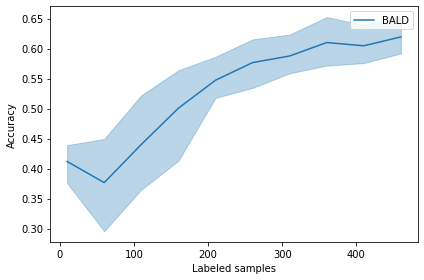

In [7]:
from cardinal.uncertainty import MarginSampler
from cardinal.random import RandomSampler
from cardinal.zhdanov2019 import TwoStepKMeansSampler
from cardinal.plotting import plot_confidence_interval
from cardinal.utils import ActiveLearningSplitter


samplers = [
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
    ('WKMeans', TwoStepKMeansSampler(10, model, batch_size, assume_fitted=True)),
    ('BALD', BALDSampler(model, batch_size, assume_fitted=True))
]

figure_accuracies = plt.figure().number
idxs = {}

for sampler_name, sampler in samplers:
    
    print('Sampler: ', sampler_name)
    
    all_accuracies = []

    for k in range(10):
        idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=500, random_state=k)

        accuracies = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # A classic active learning loop
        for j in range(n_iter):
            model.fit(X[idx.selected], y[idx.selected])
            accuracies.append(model.score(X[idx.test], y[idx.test]))
            sampler.fit(X[idx.selected], y[idx.selected])
            idx.add_batch(sampler.select_samples(X[idx.non_selected]))

        all_accuracies.append(accuracies)
    
    # Keep the last splitter
    idxs[sampler_name] = idx
    
    x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)

    plt.figure(figure_accuracies)
    plot_confidence_interval(x_data, all_accuracies, label=sampler_name)

plt.figure(figure_accuracies)
plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.show()

# Play the devil advocate 

You have now two benchmarks with two different datasets and various methods. During the first part, we highlighted that the complexity of active learning experiments could make it easy to have one method dominate the others.

This is your turn to try!

Chose a method (advice: you should consider BALD as a weak contender rather than a champion). The cell below contains experimental parameters that you are allowed to tune to make your method looks better. The second cell will run your experiment and the last one computes a score. If you method outperforms the others, do not hesitate to share it!

In [ ]:
cv_seeds = [0, 1, 2]
batch_size = 50

model = RandomForestClassifier()

samplers = [
    ('Random', RandomSampler(batch_size)),
    ('Margin', MarginSampler(model, batch_size, assume_fitted=True)),
    ('WKMeans', TwoStepKMeansSampler(10, model, batch_size, assume_fitted=True)),
    ('Proposed', YOUR_SAMPLER_HERE)
]


In [ ]:
digits = load_digits()
X, y = load_digits(return_X_y=True)
X /= 255.

n_iter = 10

sampler_accuracies = {}

for sampler_name, sampler in samplers:
    
    print('Sampler: ', sampler_name)
    
    all_accuracies = []

    for k in range(10):
        idx = ActiveLearningSplitter.train_test_split(X.shape[0], test_size=500, random_state=k)

        accuracies = []

        # For simplicity, the first batch is simply one sample from each class
        one_per_class = np.unique(y[idx.non_selected], return_index=True)[1]
        idx.add_batch(one_per_class)

        # A classic active learning loop
        for j in range(n_iter):
            model.fit(X[idx.selected], y[idx.selected])
            accuracies.append(model.score(X[idx.test], y[idx.test]))
            sampler.fit(X[idx.selected], y[idx.selected])
            idx.add_batch(sampler.select_samples(X[idx.non_selected]))

        all_accuracies.append(accuracies)
    
    sampler_accuracies[sampler] = all_accuracies


In [ ]:
# Check that proposed is best


score = len(samplers) + len(cv_seeds) + batch_size / 50 # + cd